# Arc Flow Formulation for the Cutting Stock Problem

This method is based on the article *Exact Solution of Bin-Packing Problems Using Column Generation and Branch-and-Bound* of *Carvalho (1999)*. We don't use the Columns Generation presented in the article, only the arc flow formulation.

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
from os import chdir, getcwd, listdir
from datetime import datetime

import matplotlib.pyplot as plt

import gurobipy as grb
from gurobipy import GRB
from collections import Counter

Our entry can be expressed by the tuple $(W, w, b)$, where:
- $W$ is the lenght of the roll;
- $w$ is the weight of the $m$ items;
- $b$ is the demand of the $m$ items.

First, we need to transform our entry in a directed graph, $G = (V,A)$, where:
- $V = \{0, 1, \dots, W\}$
- $A = \{(i,j) : 0 \leq i \leq j \leq W \quad and \quad j-i = w_d \quad \forall d \leq m \} $
- $A = A \cup (W, 0) $

## Graph Reduction

In this article, it is presented some criterion to reduce both the symmety of the solution space and the size of the model by considering only a subset of arcs from *A*.

### Criterion 1

An arc of size $w_e$, designated by $x_{k,k+we}$, can only have its tail at a node $k$ that is the head of another arc of size $w_d$, $x_{k–wd,k}$, for $w_d \geq w_e$, or, else, from node 0, i.e., the left border of the bin.

### Criterion 2

All the loss arcs $x_{k,k+1}$ can be set to zero for $k < w_m$.

### Criterion 3

Given any node $k$ that is the head of another arc of size $w_d (w_d > w_e)$ or $k=0$,the only valid arcs for size $w_e$ are those that start at nodes $k+sw_e,s=0,1,2, \dots , b_e – 1$ and $k + sw_e \leq W$, where be is the demand of items of size $w_e$.

In [2]:
def transform_to_graph(w, b, W):
    G = nx.DiGraph()
    min_w = np.min(w)
    
    for i in range(0, W):
        G.add_node(i)
    
    for i in range(min_w, W):
        G.add_edge(i, i+1)
    
    visited = {0}
    for d in range(0, len(w)):
        for i in range(0, b[d]):
            aux_nodes = []
            for v in visited:
                if v+w[d] in G.nodes():
                    G.add_edge(v, v+w[d])

                    aux_nodes.append(v+w[d])
                else:
                    continue
            visited.update(aux_nodes)
                
    G.add_edge(W, 0) 
    return G

When the entry is transformed to a directed graph, we can apply the following model. Let $x_{i,j}$ the **decision variable**, that represents the number of items of size $j-i$ placed in any bin at a distance of $j$ units from the beginning of the bin and $z$ the flow from $W$ to $0$. 

$
\min z \\
s.t.:  \sum_{(i,j) \in A} x_{ij} - \sum_{(j,k) \in A} x_{jk} = F(j) \qquad \\
     \sum_{(k,k+w_d) \in A} x_{k, k+w_d} \geq b_d \qquad \forall d = 1, 2, \dots, m \\
     x_{ij} \geq 0 \qquad \forall (i,j) \in A \\
     x_{ij} \in \mathbb{Z} \qquad \forall (i,j) \in A
$

where:
$
F(j) = \left \{ \begin{matrix} -z, & \mbox{if }j = 0 \\ z, & \mbox{if }j = W \\ 0, & \mbox{otherwise} \end{matrix} \right.
$

In [3]:
def integer_formulation_arc_flow(G, w, b, W):
    afcst = grb.Model("Arf flow formulation")
    
    #Creating the decision variables
    vars= {(u,v):afcst.addVar(vtype=grb.GRB.INTEGER,
                        name="x_{0}_{1}".format(u,v)) 
                for (u, v) in G.edges}
    
    #Objective Function (2) 
    objective = vars[W, 0]
    
    afcst.update()
    
    #First Restriction (3)
    for d in range(0, len(b)):
        afcst.addConstr(
                grb.quicksum(vars[k, k+w[d]] for k in G.nodes if (k, k+w[d]) in G.edges), ">", b[d]
            )
    
    ##Second Restriction (4)
    for j in G.nodes():
        if j == 0:
            afcst.addConstr(- grb.quicksum(vars[j, k] for k in list(G.successors(j))), 
                           "=", -vars[W,0])
        elif j == W:
            afcst.addConstr(grb.quicksum(vars[i, j] for i in list(G.predecessors(j))), 
                           "=", vars[W,0])
        else: 
            afcst.addConstr(grb.quicksum(vars[i, j] for i in list(G.predecessors(j))) 
                           - grb.quicksum(vars[j, k] for k in list(G.successors(j))), 
                           "=", 0)
    
    afcst.update()            
    
    afcst.ModelSense = grb.GRB.MINIMIZE
    afcst.setObjective(objective)
    
    afcst.update()
    
    return afcst, vars

## Solution

For transform the arc flow solution into a cutting stock solution, we need:
- Create a directed weight graph with the output variables of the model;
- Find a path between 0 and W;
- Decrease 1 of all the weights in the path.

The flow in the arc $(W, 0)$ is the optimal value, the paths are the best cutting patterns and the repetition of the paths in the list of paths is the quantity of a pattern need to be applied.

In [4]:
def solution(model, W):
    weights = []
    for v in model.getVars():
        if v.x!=0:
            name = v.varName.split('_')
            (u, v, w_h) = (name[1], name[2], v.x)
            u = int(u)
            v = int(v)
            weights.append((u, v, w_h))
            
    G_final = nx.DiGraph()
    G_final.add_weighted_edges_from(weights)
    
    paths = list(nx.all_simple_paths(G_final, source=0, target=W))
    edges_path = []
    while len(paths)>0:
        path = paths[0]
        path_aux = [(path[i], path[i+1]) for i in range(0, len(path)-1)] 
        edges_path.append(path_aux)

        for (u,v) in path_aux:
            G_final[u][v]["weight"] = G_final[u][v]["weight"] - 1
            if G_final[u][v]["weight"] == 0:
                G_final.remove_edge(u,v)
        paths = list(nx.all_simple_paths(G_final, source=0, target=W))
        
    return dict(Counter(map(tuple, edges_path))), G_final[W][0]["weight"]

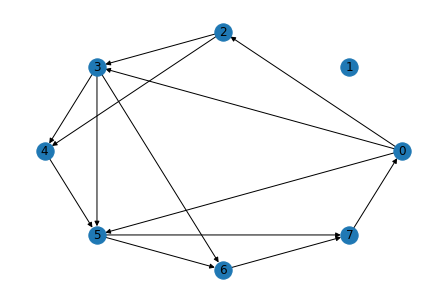

In [5]:
w = [5, 3, 2]
b = [1, 3, 2]
W = 7

G = transform_to_graph(w, b, W)

nx.draw_circular(G, with_labels= True)
plt.draw()

In [6]:
arc_flow, x = integer_formulation_arc_flow(G, w, b, W)

Academic license - for non-commercial use only - expires 2021-11-12
Using license file /Users/hismaelcosta/gurobi.lic


<ipython-input-6-260c37f16f37>:1: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  arc_flow, x = integer_formulation_arc_flow(G, w, b, W)


In [7]:
arc_flow.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 11 rows, 13 columns and 33 nonzeros
Model fingerprint: 0x0775f986
Variable types: 0 continuous, 13 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 8 rows and 8 columns
Presolve time: 0.00s
Presolved: 3 rows, 5 columns, 9 nonzeros
Variable types: 0 continuous, 5 integer (1 binary)

Root relaxation: objective 3.000000e+00, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       3.0000000    3.00000  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.04 seconds
Thread count was 4 

In [8]:
solution(arc_flow, W)

({((0, 5), (5, 7)): 1,
  ((0, 3), (3, 6), (6, 7)): 1,
  ((0, 3), (3, 5), (5, 7)): 1},
 3.0)

## Falkenauer Instances

These are the instances used by E. Falkenauer in *A hybrid grouping genetic algorithm for bin packing. Journal of Heuristics, 2(1):5–30, 1996*. They were downloaded from the OR-library. They are divided into two classes of 80 instances each: the first class has uniformly distributed item sizes **(‘Falkenauer U’)** with *n* between 120 and 1000, and *c* = 150. The instances of the second class **(‘Falkenauer T’)** includes the so-called triplets, i.e., groups of three items (one large, two small) that need to be assigned to the same bin in any optimal packing, with *n* between 60 and 501, and c = 1000.

### Falkenauer_T

In [13]:
falkenauer_t = pd.DataFrame(columns = ['instance', 'optimal', 'time', 'b&b_nodes'])

In [15]:
cam = 'Falkenauer_CSP/Falkenauer_T/'

for c in listdir(cam):
    arq = pd.read_csv(cam+c)
    
    m = int(arq.columns[0])
    W = int(arq.iloc[0].values[0])

    items = arq[1:]
    items.columns = ['w_d']

    w = [int(x[0]) for x in items.w_d.str.split('\t')]
    b = [int(x[1]) for x in items.w_d.str.split('\t')]

    now = datetime.now()
    G = transform_to_graph(w, b, W)

    arc_flow, x = integer_formulation_arc_flow(G, w, b, W)

    arc_flow.optimize()
    now1 = datetime.now()
    
    nodes = arc_flow.NodeCount
    resul = arc_flow.getObjective().getValue()
    time = now1-now
    
    entry = {'instance':c, 'optimal':resul, 'time':(time.microseconds/float(1000))%60, 'b&b_nodes': nodes}
    
    falkenauer_t = falkenauer_t.append(entry, ignore_index = True)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)


<ipython-input-15-64d7ee046faa>:18: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  arc_flow, x = integer_formulation_arc_flow(G, w, b, W)


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1138 rows, 18462 columns and 54635 nonzeros
Model fingerprint: 0x0fc5f010
Variable types: 0 continuous, 18462 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 607 rows and 357 columns
Presolve time: 0.11s
Presolved: 531 rows, 18105 columns, 53920 nonzeros
Variable types: 0 continuous, 18105 integer (0 binary)

Root relaxation: objective 8.300000e+01, 4945 iterations, 0.76 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      83.0000000   83.00000  0.00%     -    0s

Explored 0 nodes (5596 simplex iterations) in 1.00 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 83 

Optimal soluti

Model fingerprint: 0xefad32d3
Variable types: 0 continuous, 29054 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 551 rows and 302 columns
Presolve time: 0.17s
Presolved: 642 rows, 28752 columns, 85807 nonzeros
Variable types: 0 continuous, 28752 integer (0 binary)

Root relaxation: objective 1.670000e+02, 6512 iterations, 1.61 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  167.00000    0   75          -  167.00000      -     -    2s
H    0     0                     169.0000000  167.00000  1.18%     -    2s
H    0     0                     168.0000000  167.00000  0.60%     -    3s
H    0     0                     167.0000000  167.00000  0.00%     -    5s
     0     0  167.00000    0   38  167.00000  167.00000  0.00%

Optimize a model with 1197 rows, 30431 columns and 90542 nonzeros
Model fingerprint: 0x5da09e5b
Variable types: 0 continuous, 30431 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 546 rows and 296 columns
Presolve time: 0.18s
Presolved: 651 rows, 30135 columns, 89949 nonzeros
Variable types: 0 continuous, 30135 integer (0 binary)

Root relaxation: objective 1.670000e+02, 6885 iterations, 1.90 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  167.00000    0   50          -  167.00000      -     -    2s
H    0     0                     168.0000000  167.00000  0.60%     -    2s
H    0     0                     167.0000000  167.00000  0.00%     -    2s
     0     0  167.00000    0   50  167.00000  167.00000  0.00%     -   

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1140 rows, 19217 columns and 56900 nonzeros
Model fingerprint: 0xda7d3658
Variable types: 0 continuous, 19217 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 605 rows and 355 columns
Presolve time: 0.12s
Presolved: 535 rows, 18862 columns, 56189 nonzeros
Variable types: 0 continuous, 18862 integer (0 binary)

Root relaxation: objective 8.300000e+01, 6313 iterations, 1.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   83.00000    0   42          -   83.00000      -     -    1s
H    0     0                      83.9999999   83.00000  1.19%     -    1s
H    0     0   


*    0     0               0      20.0000000   20.00000  0.00%     -    0s

Explored 0 nodes (1369 simplex iterations) in 0.26 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 20 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+01, best bound 2.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1050 rows, 5076 columns and 14479 nonzeros
Model fingerprint: 0x0b1237bd
Variable types: 0 continuous, 5076 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 712 rows and 460 columns
Presolve time: 0.05s
Presolved: 338 rows, 4616 columns, 13558 nonzeros
Variable types: 0 continuous, 4616 integer (0 binary)

Root relaxation: objective 2.000000e+01, 1140 iterations, 0.07 

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 703 rows and 453 columns
Presolve time: 0.06s
Presolved: 348 rows, 5296 columns, 15589 nonzeros
Variable types: 0 continuous, 5296 integer (0 binary)

Root relaxation: objective 2.000000e+01, 1337 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      20.0000000   20.00000  0.00%     -    0s

Explored 0 nodes (1337 simplex iterations) in 0.18 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 20 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+01, best bound 2.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 

Model fingerprint: 0x330800f8
Variable types: 0 continuous, 5913 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 701 rows and 451 columns
Presolve time: 0.07s
Presolved: 353 rows, 5462 columns, 16085 nonzeros
Variable types: 0 continuous, 5462 integer (0 binary)

Root relaxation: objective 2.000000e+01, 1619 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      20.0000000   20.00000  0.00%     -    0s

Explored 0 nodes (2843 simplex iterations) in 0.28 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 20 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+01, best bound 2.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.1 build 

     0     0  167.00000    0  173  167.00000  167.00000  0.00%     -    7s

Cutting planes:
  MIR: 1
  Zero half: 2

Explored 1 nodes (17238 simplex iterations) in 7.42 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 167 169 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.670000000000e+02, best bound 1.670000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1193 rows, 29438 columns and 87563 nonzeros
Model fingerprint: 0x32c90f44
Variable types: 0 continuous, 29438 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 551 rows and 302 columns
Presolve time: 0.18s
Presolved: 642 rows, 29136 columns, 86959 nonzeros
Variable types: 0 continuous, 29136 integer (0 binary)

Root relaxati

Presolve removed 555 rows and 305 columns
Presolve time: 0.20s
Presolved: 635 rows, 28435 columns, 84858 nonzeros
Variable types: 0 continuous, 28435 integer (0 binary)

Root relaxation: objective 1.670000e+02, 7533 iterations, 2.27 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  167.00000    0   74          -  167.00000      -     -    3s
H    0     0                     169.0000000  167.00000  1.18%     -    3s
H    0     0                     168.0000000  167.00000  0.60%     -    3s
H    0     0                     167.0000000  167.00000  0.00%     -    3s
     0     0  167.00000    0   74  167.00000  167.00000  0.00%     -    3s

Explored 1 nodes (15317 simplex iterations) in 3.35 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 167 168 169 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.670000000000e+02, best bound 1

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   40.00000    0   39          -   40.00000      -     -    0s
H    0     0                      41.0000000   40.00000  2.44%     -    0s
     0     0   40.00000    0   35   41.00000   40.00000  2.44%     -    0s
*    0     0               0      40.0000000   40.00000  0.00%     -    0s

Cutting planes:
  Zero half: 6

Explored 1 nodes (6060 simplex iterations) in 0.98 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 40 41 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+01, best bound 4.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1139 rows, 19021 columns and 56312 nonzeros
Model fingerprint: 0x5be266c4
Variable types: 0 continuous, 19021 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 546 rows and 297 columns
Presolve time: 0.19s
Presolved: 652 rows, 30310 columns, 90476 nonzeros
Variable types: 0 continuous, 30310 integer (0 binary)

Root relaxation: objective 1.670000e+02, 5943 iterations, 1.75 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  167.00000    0  123          -  167.00000      -     -    2s
H    0     0                     169.0000000  167.00000  1.18%     -    3s
H    0     0                     168.0000000  167.00000  0.60%     -    4s
     0     0  167.00000    0   16  168.00000  167.00000  0.60%     -    6s
*    0     0               0     167.0000000  167.00000  0.00%     -    6s

Explored 1 nodes (23363 simplex iterations) in 6.49 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 167


Solution count 3: 40 41 42 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+01, best bound 4.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1142 rows, 19206 columns and 56867 nonzeros
Model fingerprint: 0x8c036404
Variable types: 0 continuous, 19206 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 603 rows and 353 columns
Presolve time: 0.12s
Presolved: 539 rows, 18853 columns, 56160 nonzeros
Variable types: 0 continuous, 18853 integer (0 binary)

Root relaxation: objective 8.300000e+01, 4238 iterations, 0.80 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0 

H    0     0                      40.0000000   40.00000  0.00%     -    1s
     0     0   40.00000    0   79   40.00000   40.00000  0.00%     -    1s

Cutting planes:
  Zero half: 3

Explored 1 nodes (3992 simplex iterations) in 1.61 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 40 42 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+01, best bound 4.000000000000e+01, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1089 rows, 11357 columns and 33320 nonzeros
Model fingerprint: 0x10d3a944
Variable types: 0 continuous, 11357 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 658 rows and 408 columns
Presolve time: 0.11s
Presolved: 431 rows, 10949 columns, 32503 nonzeros
Variab

In [16]:
falkenauer_t

,instance,optimal,time,b&b_nodes
0,Falkenauer_t249_07.txt,83.0,49.846,0.0
1,Falkenauer_t120_09.txt,40.0,55.353,1.0
2,Falkenauer_t249_13.txt,83.0,53.663,0.0
3,Falkenauer_t249_12.txt,83.0,41.887,1.0
4,Falkenauer_t249_06.txt,83.0,29.892,1.0
...,...,...,...,...
75,Falkenauer_t120_05.txt,40.0,4.529,1.0
76,Falkenauer_t120_04.txt,40.0,15.931,1.0
77,Falkenauer_t120_10.txt,40.0,32.177,0.0
78,Falkenauer_t501_03.txt,167.0,50.516,1.0


### Falkenauer_U

In [17]:
falkenauer_u = pd.DataFrame(columns = ['instance', 'optimal', 'time', 'b&b_nodes'])

In [18]:
cam = 'Falkenauer_CSP/Falkenauer_U/'

for c in listdir(cam):
    arq = pd.read_csv(cam+c)
    
    m = int(arq.columns[0])
    W = int(arq.iloc[0].values[0])

    items = arq[1:]
    items.columns = ['w_d']

    w = [int(x[0]) for x in items.w_d.str.split('\t')]
    b = [int(x[1]) for x in items.w_d.str.split('\t')]

    now = datetime.now()
    G = transform_to_graph(w, b, W)

    arc_flow, x = integer_formulation_arc_flow(G, w, b, W)

    arc_flow.optimize()
    now1 = datetime.now()
    
    nodes = arc_flow.NodeCount
    resul = arc_flow.getObjective().getValue()
    time = now1-now
    
    entry = {'instance':c, 'optimal':resul, 'time':(time.microseconds/float(1000))%60, 'b&b_nodes': nodes}
    
    falkenauer_u = falkenauer_u.append(entry, ignore_index = True)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 232 rows, 3347 columns and 9910 nonzeros
Model fingerprint: 0x5d73b2b8
Variable types: 0 continuous, 3347 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 991.0000000
Presolve removed 63 rows and 19 columns
Presolve time: 0.02s
Presolved: 169 rows, 3328 columns, 9847 nonzeros
Variable types: 0 continuous, 3328 integer (0 binary)

Root relaxation: objective 2.050867e+02, 1156 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  205.08667    0   66  991.00000  205.08667  79.3%     -    0s
H    0     0                     206.0000000  205.0

<ipython-input-18-0cb2680d887d>:18: DeprecationWarning: Deprecated, pass a TempConstr or use Model.addLConstr
  arc_flow, x = integer_formulation_arc_flow(G, w, b, W)


Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 232 rows, 3347 columns and 9910 nonzeros
Model fingerprint: 0xd2d51c9e
Variable types: 0 continuous, 3347 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 63 rows and 19 columns
Presolve time: 0.02s
Presolved: 169 rows, 3328 columns, 9847 nonzeros
Variable types: 0 continuous, 3328 integer (0 binary)

Root relaxation: objective 1.994267e+02, 1378 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  199.42667    0   72          -  199.42667      -     -    0s
H    0     0                     201.0000000  199.42667  0.78%     -    0s
     0     0  199.42667 

H    0     0                     204.0000000  203.98000  0.01%     -    0s
     0     0  203.98000    0   60  204.00000  203.98000  0.01%     -    0s

Explored 1 nodes (3691 simplex iterations) in 0.35 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 204 205 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.040000000000e+02, best bound 2.040000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 232 rows, 3345 columns and 9904 nonzeros
Model fingerprint: 0x9f7c2b15
Variable types: 0 continuous, 3345 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 63 rows and 19 columns
Presolve time: 0.02s
Presolved: 169 rows, 3326 columns, 9841 nonzeros
Variable types: 0 continuous, 3326 integer (

H    0     0                     199.0000000  197.58000  0.71%     -    0s
     0     0  197.58000    0   89  199.00000  197.58000  0.71%     -    0s
H    0     0                     198.0000000  197.58000  0.21%     -    0s
     0     0  197.58000    0   89  198.00000  197.58000  0.21%     -    0s

Cutting planes:
  Zero half: 1

Explored 1 nodes (2353 simplex iterations) in 0.34 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 198 199 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.980000000000e+02, best bound 1.980000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 232 rows, 3348 columns and 9913 nonzeros
Model fingerprint: 0xcae7b064
Variable types: 0 continuous, 3348 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS 


     0     0  399.33333    0   63          -  399.33333      -     -    0s
H    0     0                     401.0000000  399.33333  0.42%     -    0s
     0     0  399.33333    0   88  401.00000  399.33333  0.42%     -    0s
H    0     0                     400.0000000  399.33333  0.17%     -    0s
     0     0  399.33333    0   88  400.00000  399.33333  0.17%     -    0s

Cutting planes:
  Zero half: 2

Explored 1 nodes (1876 simplex iterations) in 0.44 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 400 401 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+02, best bound 4.000000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 218 rows, 2550 columns and 7519 nonzeros
Model fingerprint: 0x8ff0b0d9
Variable types: 0 continuous, 2550 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00

Model fingerprint: 0xe0fcfdb1
Variable types: 0 continuous, 3348 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+01]
Presolve removed 63 rows and 19 columns
Presolve time: 0.02s
Presolved: 169 rows, 3329 columns, 9850 nonzeros
Variable types: 0 continuous, 3329 integer (0 binary)

Root relaxation: objective 3.969267e+02, 1392 iterations, 0.09 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  396.92667    0   55          -  396.92667      -     -    0s
H    0     0                     398.0000000  396.92667  0.27%     -    0s
     0     0  396.92667    0   70  398.00000  396.92667  0.27%     -    0s
     0     0  397.00000    0   75  398.00000  397.00000  0.25%     -    0s
     0     0  397.00000    0   57  398.00000  397.00000  0.25%     -


Explored 1 nodes (1392 simplex iterations) in 0.12 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 103 104 577 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.030000000000e+02, best bound 1.030000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 232 rows, 3348 columns and 9913 nonzeros
Model fingerprint: 0xbf550aa2
Variable types: 0 continuous, 3348 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+01]
Presolve removed 63 rows and 19 columns
Presolve time: 0.02s
Presolved: 169 rows, 3329 columns, 9850 nonzeros
Variable types: 0 continuous, 3329 integer (0 binary)

Root relaxation: objective 3.984933e+02, 1279 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  399.34000    0   67          -  399.34000      -     -    0s
H    0     0                     400.0000000  399.34000  0.16%     -    0s
     0     0  399.34000    0   67  400.00000  399.34000  0.16%     -    0s

Explored 1 nodes (1924 simplex iterations) in 0.22 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 400 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.000000000000e+02, best bound 4.000000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 232 rows, 3348 columns and 9913 nonzeros
Model fingerprint: 0xebf17c1a
Variable types: 0 continuous, 3348 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 65 rows and 21 columns
Presolve time: 0.02s
Presolved: 163 rows, 3041 columns, 8988 nonzeros
Variable types: 0 continuous, 3041 integer (0 binary)

Root relaxation: objective 1.043946e+02, 1232 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  104.39456    0   58          -  104.39456      -     -    0s
H    0     0                     105.0000000  104.39456  0.58%     -    0s
     0     0  104.39456    0   58  105.00000  104.39456  0.58%     -    0s

Explored 1 nodes (1498 simplex iterations) in 0.18 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 105 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.050000000000e+02, best bound 1.050000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 

Variable types: 0 continuous, 3329 integer (0 binary)

Root relaxation: objective 4.031600e+02, 1252 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  403.16000    0   71          -  403.16000      -     -    0s
H    0     0                     404.0000000  403.16000  0.21%     -    0s
     0     0  403.16000    0   71  404.00000  403.16000  0.21%     -    0s

Explored 1 nodes (1382 simplex iterations) in 0.25 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 404 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.040000000000e+02, best bound 4.040000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 232 rows, 3348 columns and 9913 nonzeros
Model fingerprint: 0xa5d122ad
Variable types: 0 c

Variable types: 0 continuous, 3065 integer (0 binary)

Root relaxation: objective 1.048611e+02, 946 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  104.86111    0   44          -  104.86111      -     -    0s
H    0     0                     106.0000000  104.86111  1.07%     -    0s
H    0     0                     105.0000000  104.86111  0.13%     -    0s
     0     0  104.86111    0   44  105.00000  104.86111  0.13%     -    0s

Explored 1 nodes (1453 simplex iterations) in 0.19 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 105 106 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.050000000000e+02, best bound 1.050000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 216 rows, 24

Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 213 rows, 2261 columns and 6652 nonzeros
Model fingerprint: 0xfc25429a
Variable types: 0 continuous, 2261 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 63 rows and 25 columns
Presolve time: 0.02s
Presolved: 150 rows, 2236 columns, 6583 nonzeros
Variable types: 0 continuous, 2236 integer (0 binary)

Root relaxation: objective 4.801333e+01, 849 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   48.01333    0   42          -   48.01333      -     -    0s
H    0     0                      49.0000000   48.01333  2.01%     -    0s
     0     0   48.01333    0   42   49.00000   48.01333  2.01%     -    0s

Expl

Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 227 rows, 3053 columns and 9028 nonzeros
Model fingerprint: 0x9633a5d5
Variable types: 0 continuous, 3053 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+00]
Presolve removed 63 rows and 21 columns
Presolve time: 0.02s
Presolved: 164 rows, 3032 columns, 8963 nonzeros
Variable types: 0 continuous, 3032 integer (0 binary)

Root relaxation: objective 1.014218e+02, 1002 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  101.42177    0   49          -  101.42177      -     -    0s
H    0     0                     102.0000000  101.42177  0.57%     -    0s
     0     0  101.42177    0   49  102.00000  101.42177  0.57%     -    0s

Exp

H    0     0                     402.0000000  401.80667  0.05%     -    0s
     0     0  401.80667    0   84  402.00000  401.80667  0.05%     -    0s

Cutting planes:
  Zero half: 1

Explored 1 nodes (1909 simplex iterations) in 0.60 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 402 403 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.020000000000e+02, best bound 4.020000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 213 rows, 2191 columns and 6442 nonzeros
Model fingerprint: 0x93a2aed1
Variable types: 0 continuous, 2191 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 64 rows and 25 columns
Presolve time: 0.02s
Presolved: 149 rows, 2166 columns, 6372 nonzeros
Variable typ

Presolve time: 0.02s
Presolved: 169 rows, 3329 columns, 9850 nonzeros
Variable types: 0 continuous, 3329 integer (0 binary)

Root relaxation: objective 2.012933e+02, 1340 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  201.29333    0   65          -  201.29333      -     -    0s
H    0     0                     202.0000000  201.29333  0.35%     -    0s
     0     0  201.29333    0   65  202.00000  201.29333  0.35%     -    0s

Explored 1 nodes (2404 simplex iterations) in 0.23 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 202 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.020000000000e+02, best bound 2.020000000000e+02, gap 0.0000%
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 232 rows, 3347 colum

In [19]:
falkenauer_u

,instance,optimal,time,b&b_nodes
0,Falkenauer_u500_05.txt,206.0,26.864,1.0
1,Falkenauer_u500_11.txt,200.0,41.138,1.0
2,Falkenauer_u500_10.txt,200.0,32.509,1.0
3,Falkenauer_u500_04.txt,206.0,50.302,1.0
4,Falkenauer_u500_12.txt,199.0,50.212,1.0
...,...,...,...,...
75,Falkenauer_u250_17.txt,100.0,11.030,1.0
76,Falkenauer_u500_18.txt,202.0,40.964,1.0
77,Falkenauer_u500_19.txt,196.0,56.139,1.0
78,Falkenauer_u500_09.txt,202.0,17.414,1.0
